## Занятие 12. Foundational Vision Models

Фундаментальные модели ([вики](https://en.wikipedia.org/wiki/Foundation_models)) - это модели,
- с большим количеством параметров, обученные на больших датасетах,
- **которые можно адаптировать для решения широкого набора задач** (без переобучения)

Фундаментальные модели в NLP широко известны: по prompt-запросу от пользователя они могут решать задачи суммаризации текста, ответа на вопрос,  оценки тональности, распознавания именованных сущностей и других. Одна модель оценивавется на множестве задач (например - [SuperGlue Benchmark](https://w4ngatang.github.io/static/papers/superglue.pdf) )

В 2023 году был опубликован ряд работ по фундаментальным моделям в CV.


### 1.Segment Anything
https://arxiv.org/pdf/2304.02643.pdf

Фундаментальная модель по сегментации объектов по prompt-у:
- ключевым точкам
- прямоугольнику
- маске

![img](imgs/fig1.png)


#### 1.0 Подготовка

In [1]:
from pathlib import Path
import numpy as np
ROOT = Path().absolute()
assert ROOT.name == "c12"

In [2]:
from matplotlib import pyplot as plt

In [3]:
import requests
from tqdm import tqdm

def download_file(url, n_chunk=1):
    fname = url.split('/')[-1]
    if Path(fname).exists():
        return fname
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise ValueError(str(r))
        
    block_size = 5 * 1024
    file_size = int(response.headers.get('Content-Length', None))
    num_bars = file_size // (n_chunk * block_size)
    progress_bar = tqdm(total=file_size, unit='iB', unit_scale=True)
    with open(fname, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    return fname

In [4]:
_VIT_B_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth"
_VIT_B_NAME = download_file(_VIT_B_URL)
_VIT_B_NAME

'sam_vit_b_01ec64.pth'

In [5]:
_VIT_H_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
_VIT_H_NAME = download_file(_VIT_H_URL)
_VIT_H_NAME

'sam_vit_h_4b8939.pth'

In [6]:
import cv2

def read_image(pth):
    image = cv2.imread(str(pth.absolute()))
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

In [7]:
import torch
from segment_anything import SamPredictor, sam_model_registry
sam_model_registry

F:\bzimka\condaenvs\segany\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{'default': <function segment_anything.build_sam.build_sam_vit_h(checkpoint=None)>,
 'vit_h': <function segment_anything.build_sam.build_sam_vit_h(checkpoint=None)>,
 'vit_l': <function segment_anything.build_sam.build_sam_vit_l(checkpoint=None)>,
 'vit_b': <function segment_anything.build_sam.build_sam_vit_b(checkpoint=None)>}

In [8]:
sam_ckpts = {
    'vit_b' : ROOT / _VIT_B_NAME,
    'vit_h' : ROOT / _VIT_H_NAME,
}

In [9]:
mtype = 'vit_b'
sam = sam_model_registry[mtype](checkpoint=str(sam_ckpts[mtype]))
sam.to(device="cuda");


In [10]:
from torch import nn

print(
    f"{sum(p.numel() for p in sam.parameters()) / 1e6:1.3f} M params"
)

93.735 M params


### 1.1 Примеры

In [11]:
ROOT.parent / "c11" / "f_r_74_.jpg"

WindowsPath('F:/bzimka/edu/course_cvdl/classes/c11/f_r_74_.jpg')

In [12]:
predictor = SamPredictor(sam)

In [13]:
img1 = read_image(ROOT.parent / "c05" / "images" / "puppy.jpg")
pts1 = np.array([[380, 220]])
pts1b = np.array([[380, 220], [380, 150]])
pts1c = np.array([[380, 220], [380, 150], [250, 250]])

img2  = read_image(ROOT.parent / "c11" / "f_r_74_.jpg" )
pts2 = np.array([[450, 250]]) 
box2 = np.array([330, 180, 620, 400])


img3 = read_image(ROOT / "imgs" / "mipt.webp")
pts3 = np.array([[600, 350]])
pts3b = np.array([
    [450, 300],
    [750, 300],
])
pts3c = np.array([
    [450, 300],
    [750, 300],
    [800, 150],
    [600, 150],
    [100, 200]
])

In [14]:
image = img1
input_point = pts1
input_box = None
input_mask = None

input_label = np.ones(len(input_point))

#input_label[-1] = 0
#input_mask = best_mask


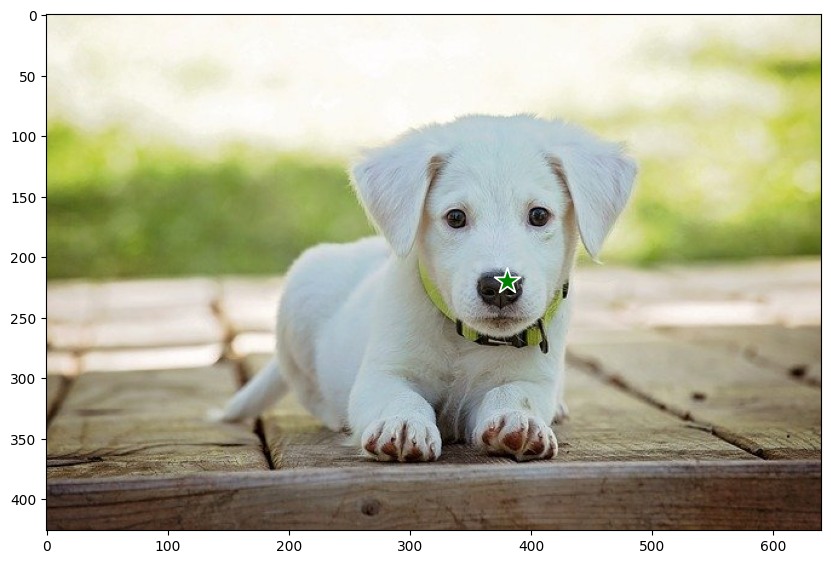

In [15]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
if input_box is not None:
    show_box(input_box, plt.gca())
plt.axis('on')
plt.show() 

In [16]:
%%time
predictor.set_image(image)


CPU times: total: 484 ms
Wall time: 490 ms


In [17]:
%%time
masks, scores, logits = predictor.predict(point_coords=input_point, point_labels=input_label, box=input_box, mask_input=input_mask)

CPU times: total: 172 ms
Wall time: 174 ms


In [18]:
masks.shape

(3, 426, 640)

In [19]:
masks.shape

(3, 426, 640)

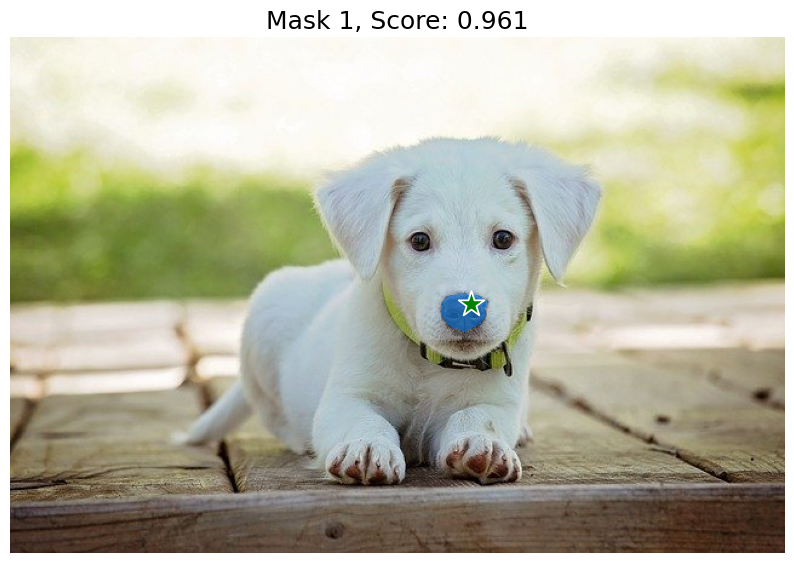

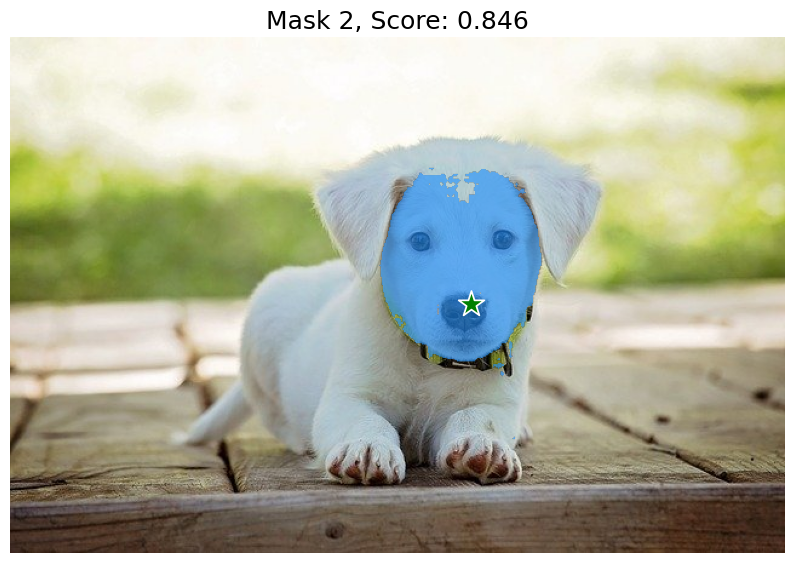

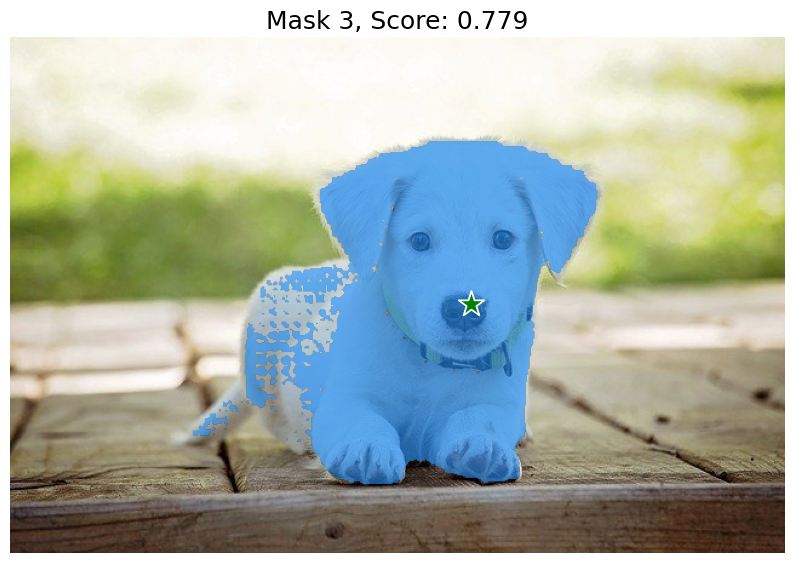

In [20]:

for i, (mask, score) in enumerate(sorted(zip(masks, scores), key=lambda x: -x[1])):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  



In [21]:
masks, scores, logits = predictor.predict(
    point_coords=input_point, 
    point_labels=input_label, 
    box=input_box, 
    mask_input=input_mask,
    multimask_output=False,
    return_logits=True
)
best_mask = masks[0]
best_mask = cv2.resize(best_mask, (256, 256))[None]
best_mask.shape, best_mask.dtype

((1, 256, 256), dtype('float32'))

### 1.2. Компоненты
- image_encoder
- prompt_encoder
- mask_decoder

![img](imgs/fig4.png)

In [22]:
for n, m in sam.named_children():
    print(n)

image_encoder
prompt_encoder
mask_decoder


#### **image_encoder** - отображает изображение в карту признаков

$image\_embeddings[D, H/16, W/16] = encoder(image[C, H, W])$

ViT с небольшими модификациями:
- window attention ([ViTDet](https://arxiv.org/pdf/2203.16527.pdf)) - как в SWIN, но без сдвигов и изменения масштабов
- decomposed relative position encoding в каждом attention ([Multiscale Vision Transformers v2](https://openaccess.thecvf.com/content/CVPR2022/papers/Li_MViTv2_Improved_Multiscale_Vision_Transformers_for_Classification_and_Detection_CVPR_2022_paper.pdf)) 

Предварительно обучается через [Masked Auto Encoding](https://openaccess.thecvf.com/content/CVPR2022/papers/He_Masked_Autoencoders_Are_Scalable_Vision_Learners_CVPR_2022_paper.pdf).

In [23]:
sam.image_encoder

ImageEncoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): MLPBlock(
        (lin1): Linear(in_features=768, out_features=3072, bias=True)
        (lin2): Linear(in_features=3072, out_features=768, bias=True)
        (act): GELU(approximate='none')
      )
    )
  )
  (neck): Sequential(
    (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): LayerNorm2d()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): LayerNorm2d()
  )
)

In [24]:
print(
    f"{sum(p.numel() for p in sam.image_encoder.parameters()) / 1e6:1.3f} M params"
)

89.671 M params


In [25]:
bl = sam.image_encoder.blocks[-3]
bl.window_size

14

In [26]:
# Подготовка изображения
input_image = predictor.transform.apply_image(image)
input_image_torch = torch.as_tensor(input_image, device=torch.device('cuda:0'))

input_image_torch = input_image_torch.permute(2, 0, 1).contiguous()[None, :, :, :]
x0 = sam.preprocess(input_image_torch)


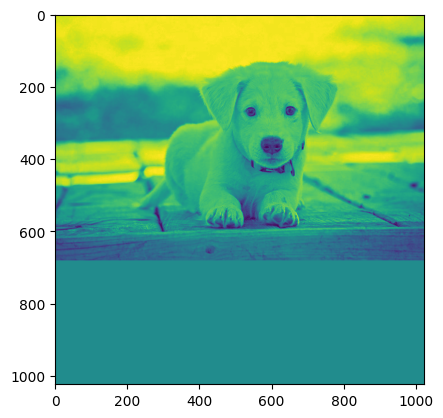

In [27]:
plt.imshow(x0[0, 0].cpu())

In [28]:
sam.image_encoder.patch_embed

PatchEmbed(
  (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
)

In [29]:
# токенизируем изображение
x1 = sam.image_encoder.patch_embed(x0)
x1.shape

torch.Size([1, 64, 64, 768])

In [30]:
# добавляем позиционные энкодинги
x2 = x1 + sam.image_encoder.pos_embed

In [31]:
# вычисляем фичи
_x = x2
for blk in sam.image_encoder.blocks:
    _x = blk(_x)

x3 = _x
x3.shape

torch.Size([1, 64, 64, 768])

In [32]:
# поижаем размерность признаков
features = sam.image_encoder.neck(x3.permute(0, 3, 1, 2))
features.shape

torch.Size([1, 256, 64, 64])

##### **prompt_encoder** - отображает prompt всех модальностей в токены.
- points, bbox - в токены $sparse[N, D]$
- masks - в токены $dense[h, w, D]$


In [33]:
sam.prompt_encoder

PromptEncoder(
  (pe_layer): PositionEmbeddingRandom()
  (point_embeddings): ModuleList(
    (0-3): 4 x Embedding(1, 256)
  )
  (not_a_point_embed): Embedding(1, 256)
  (mask_downscaling): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(2, 2))
    (1): LayerNorm2d()
    (2): GELU(approximate='none')
    (3): Conv2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
    (4): LayerNorm2d()
    (5): GELU(approximate='none')
    (6): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  )
  (no_mask_embed): Embedding(1, 256)
)

In [34]:
print(
    f"{sum(p.numel() for p in sam.prompt_encoder.parameters()) / 1e3:1.3f} K params"
)

6.220 K params


**Sparse embeddings**

Варианты sparse prompt, для которых надо закодировать 2D-локацию:
- point positive
- point negative
- bbox -> 2 точки top-left и bot-right

$sparse[i] = pos(x[i], y[i]) + semantic(cls[i])$

[Описание pos-encoding](https://proceedings.neurips.cc/paper/2020/file/55053683268957697aa39fba6f231c68-Paper.pdf) 


**Dense embedding**

Dense prompt - маска
- если присутствоет, то $dense = CNN(mask)$
- если осутствует, то $dense = param$



In [35]:
coords_torch = torch.as_tensor(
    predictor.transform.apply_coords(input_point, image.shape[:-1]), 
    dtype=torch.float, device=torch.device('cuda:0')
)
labels_torch = torch.as_tensor(input_label, dtype=torch.int, device=torch.device('cuda:0'))
coords_torch, labels_torch = coords_torch[None, :, :], labels_torch[None, :]
coords_torch, labels_torch

(tensor([[[608.0000, 352.2066]]], device='cuda:0'),
 tensor([[1]], device='cuda:0', dtype=torch.int32))

In [36]:
sparse_embeddings, dense_embeddings = sam.prompt_encoder(
    points=(coords_torch, labels_torch),
    boxes=None,
    masks=None,
)

In [37]:
sparse_embeddings.shape, dense_embeddings.shape

(torch.Size([1, 2, 256]), torch.Size([1, 256, 64, 64]))

##### **mask_decoder** - отображает prompt через карту признаков в бинарные маски

Предсказание масок с помощью VT: [MaskFormer](https://proceedings.neurips.cc/paper_files/paper/2021/file/950a4152c2b4aa3ad78bdd6b366cc179-Paper.pdf)

Основная идея: вместо предсказания per-pixel класса - предсказывать N масок, затем классифицировать каждую маску (semantic label / instance label)

![img](imgs/fig1ms.png)

 


Этапы предсказания:
- объединение sparse токенов из prompt с "техническими" токенами для масок
- обработка sparse, (image+dense) embeddings трансформером
- upscale полученных dense признаков в 4 раза
- извлечение из sparse токенов технических токенов для масок
- предсказание для каждого маск-токена 2D маски через скалярное произведение
- предсказание для каждого маск-токена оценки уверенности

![img](imgs/fig14.png)

In [38]:
with torch.no_grad():
    low_res_masks, iou_predictions = sam.mask_decoder(
        image_embeddings=features,
        image_pe=sam.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )

In [39]:
low_res_masks.shape, iou_predictions


(torch.Size([1, 1, 256, 256]), tensor([[0.9356]], device='cuda:0'))

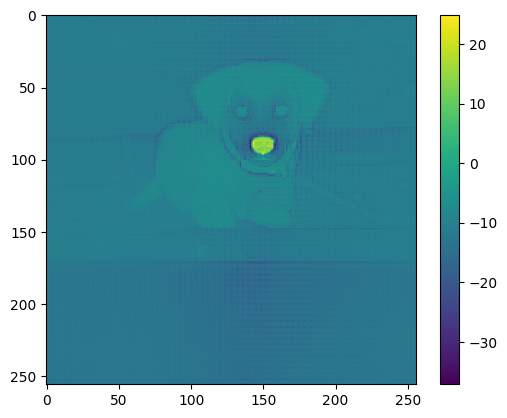

In [40]:
plt.imshow(low_res_masks[0, 0,].cpu())
plt.colorbar()

#### 1.3. Предсказание множества масок

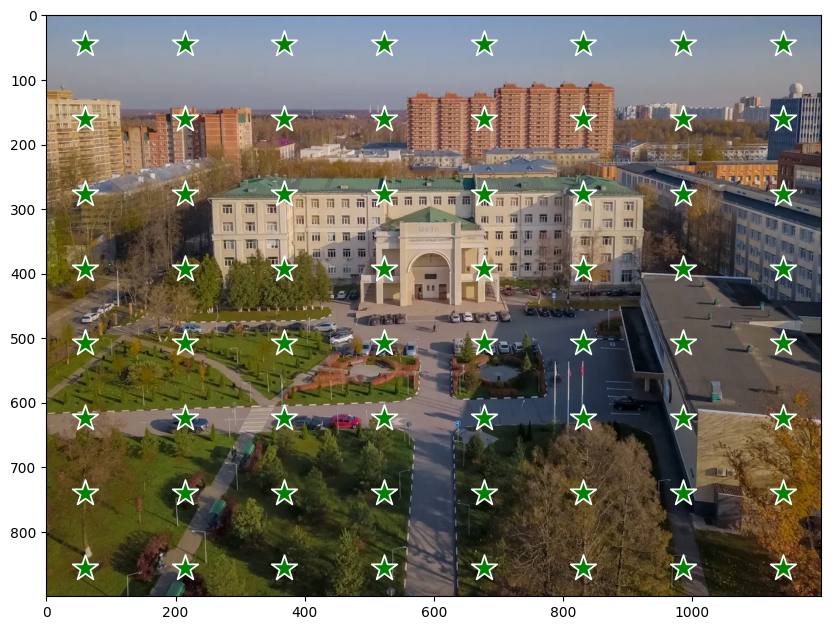

In [41]:
xs = np.linspace(0.05, 0.95, 8) * img3.shape[1]
ys = np.linspace(0.05, 0.95, 8) * img3.shape[0]
xs, ys = np.meshgrid(xs, ys)

points2d = np.stack((xs, ys), axis=-1).astype(float)
points = points2d.reshape(-1, 2)
points.shape, points2d.shape

plt.figure(figsize=(10,10))
plt.imshow(img3)
show_points(points, np.ones(len(points)), plt.gca())
plt.axis('on')
plt.show() 

In [42]:
from segment_anything.automatic_mask_generator import SamAutomaticMaskGenerator
sam_gen = SamAutomaticMaskGenerator(
    model=sam, 
    points_per_side=16,
    points_per_batch=16,
)

In [43]:
masks = sam_gen.generate(img2)
len(masks)

17

In [44]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 184939,
 'bbox': [0, 2, 639, 475],
 'predicted_iou': 1.0175739526748657,
 'point_coords': [[540.0, 195.0]],
 'stability_score': 0.9693617820739746,
 'crop_box': [0, 0, 640, 480]}

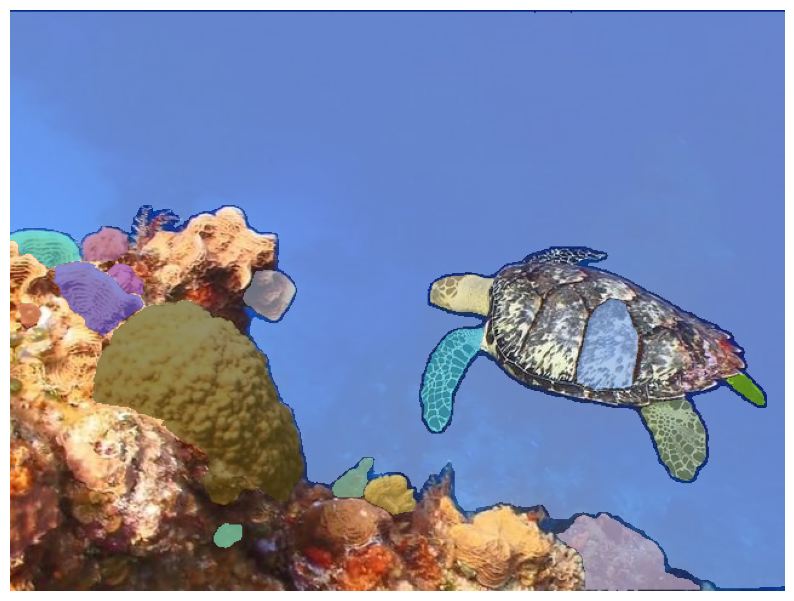

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(img2)
for m in masks:
    show_mask(m['segmentation'], plt.gca(), random_color=True)
plt.axis('off')
plt.show()  

### 2.Grounding DINO
![img](imgs/gdino.png)
Мультимодальный детектор объктов из открытого множества классов, принимающий prompt-запрос в виде текста.

https://arxiv.org/abs/2303.05499

#### 2.0 Подготовка
Установка пакета требует C++ компиллятор и CUDA (nvcc) .

In [46]:
GD_URL = "https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth"
GD_NAME = download_file(GD_URL)

In [47]:
from groundingdino.util.inference import load_model, load_image, predict, annotate
import cv2

plt.rcParams['figure.figsize'] = (10, 15)

gdino = load_model("GRoundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py", GD_NAME)
IMAGE_PATH = "imgs/mipt.webp"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25


F:\bzimka\condaenvs\segany\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


In [53]:
for (n, child) in gdino.named_children():
    num_par = sum(p.numel() for p in child.parameters())
    print(f"{n}: {num_par/1e6: 1.3f}M")

transformer:  33.523M
bert:  109.482M
feat_map:  0.197M
input_proj:  2.117M
backbone:  27.521M
bbox_embed:  0.133M
class_embed:  0.000M


In [54]:
image_source, image = load_image(IMAGE_PATH)
image_source.shape, image.shape

((900, 1200, 3), torch.Size([3, 800, 1066]))

#### 2.1 Примеры

In [55]:
TEXT_PROMPT = "building"
TEXT_PROMPT = "building. tree. car"
TEXT_PROMPT = "building with green roof."
TEXT_PROMPT = "the entrance of building with green roof."
TEXT_PROMPT = "the most distant building only."


boxes, logits, phrases = predict(
    model=gdino,
    image=image,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)


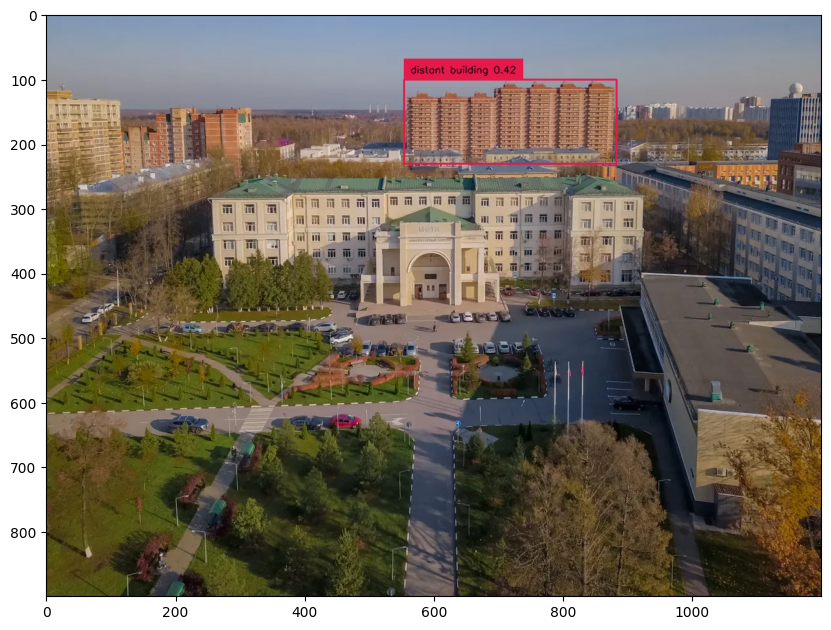

In [56]:
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))

#### 2.2 GroundingDINO + ImageInpaint

In [57]:
import torch
from diffusers import StableDiffusionInpaintPipeline

stdiff = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)

stdiff = stdiff.to("cuda")

Loading pipeline components...: 100%|████████████████████████████████████████████████████| 6/6 [00:05<00:00,  1.02it/s]


In [58]:
from torchvision.ops import box_convert
from PIL import Image

def generate_masks_with_grounding(image_source, boxes):
    h, w, _ = image_source.shape
    boxes_unnorm = boxes * torch.Tensor([w, h, w, h])
    boxes_xyxy = box_convert(boxes=boxes_unnorm, in_fmt="cxcywh", out_fmt="xyxy").numpy()
    mask = np.zeros_like(image_source)
    for box in boxes_xyxy:
        x0, y0, x1, y1 = box
        mask[int(y0):int(y1), int(x0):int(x1), :] = 255
    return mask

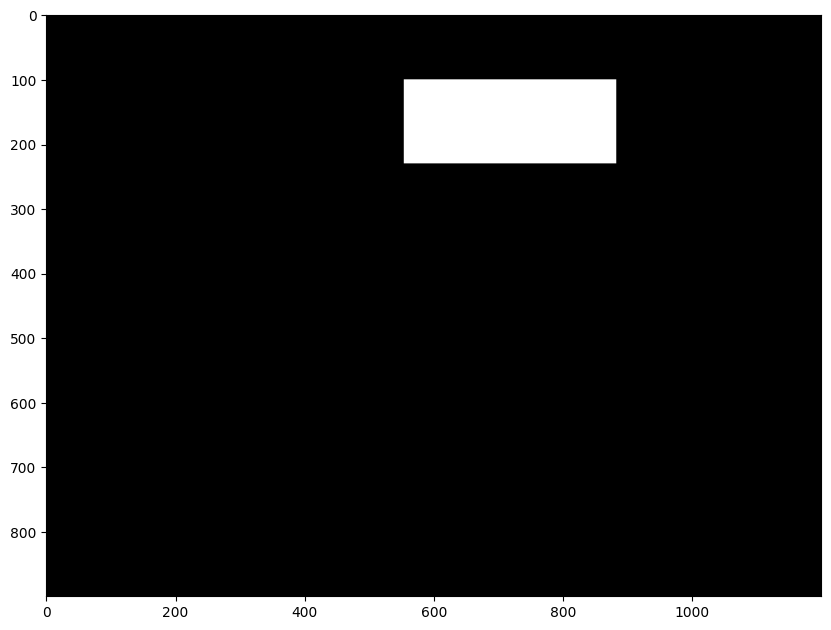

In [59]:
image_mask = generate_masks_with_grounding(image_source, boxes)
plt.imshow(image_mask)

In [60]:
pil_image_source = Image.fromarray(image_source)
pil_annotated_frame = Image.fromarray(annotated_frame)
pil_image_mask = Image.fromarray(image_mask)

pil_image_source_for_inpaint = pil_image_source.resize((512, 512))
pil_image_mask_for_inpaint = pil_image_mask.resize((512, 512))

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 19.54it/s]


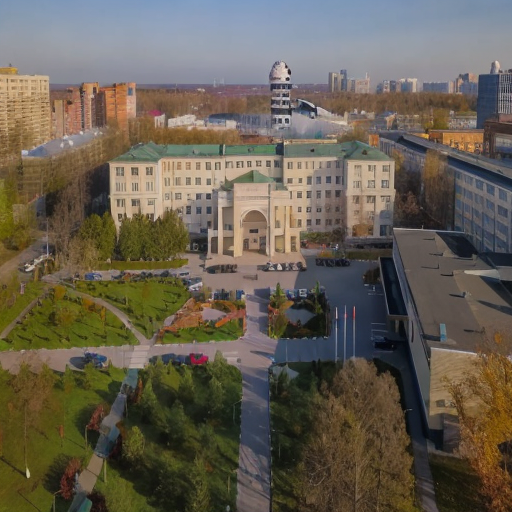

In [195]:
prompt = "huge spaceships and  rockets"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_inpainting = stdiff(prompt=prompt, image=pil_image_source_for_inpaint, mask_image=pil_image_mask_for_inpaint).images[0]
image_inpainting

#### 2.3 GroundingDino + SAM + Image Inpaint

F:\bzimka\condaenvs\segany\lib\site-packages\transformers\modeling_utils.py:907: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
F:\bzimka\condaenvs\segany\lib\site-packages\torch\utils\checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
F:\bzimka\condaenvs\segany\lib\site-packages\torch\utils\checkpoint.py:61: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


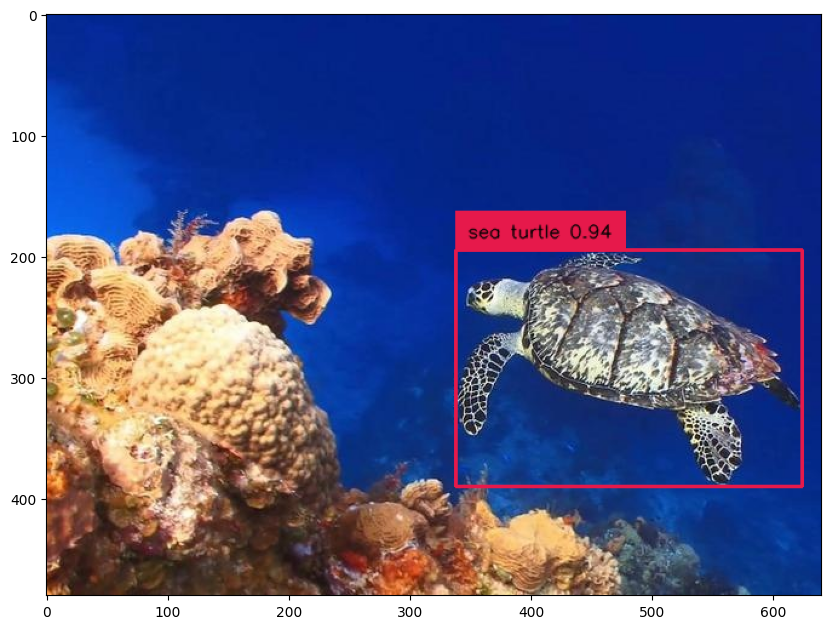

In [61]:
image_source, image = load_image(ROOT.parent / "c11" / "f_r_74_.jpg")

boxes, logits, phrases = predict(
    model=gdino,
    image=image,
    caption="Sea turtle.",
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD
)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))

In [62]:
input_box

In [63]:
h, w, _ = image_source.shape
boxe_scaled = boxes * torch.Tensor([w, h, w, h])
xyxy = box_convert(boxes=boxe_scaled, in_fmt="cxcywh", out_fmt="xyxy").numpy().flatten().round().astype(int)
xyxy

array([338, 196, 624, 390])

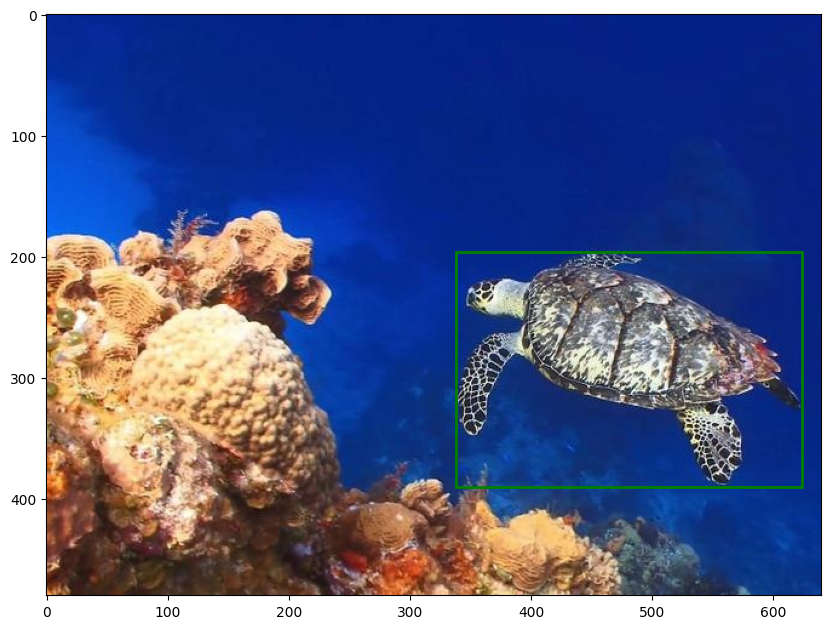

In [64]:
plt.figure(figsize=(10,10))
plt.imshow(image_source)
show_box(xyxy, plt.gca())
plt.axis('on')
plt.show() 

In [65]:
predictor.set_image(np.array(image_source))
masks, scores, logits = predictor.predict(
    box=xyxy, 
    mask_input=input_mask,
    multimask_output=False,
    return_logits=False
)

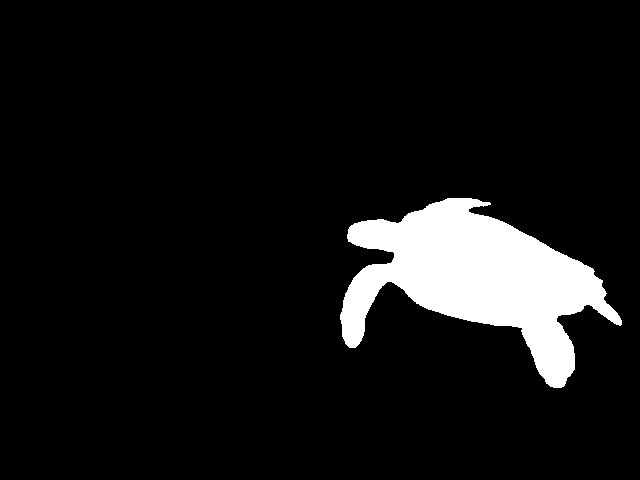

In [66]:
pil_image_source = Image.fromarray(image_source)
pil_image_mask = Image.fromarray(masks[0])

pil_image_source_for_inpaint = pil_image_source.resize((512, 512))
pil_image_mask_for_inpaint = pil_image_mask.resize((512, 512))
pil_image_mask


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 18.89it/s]


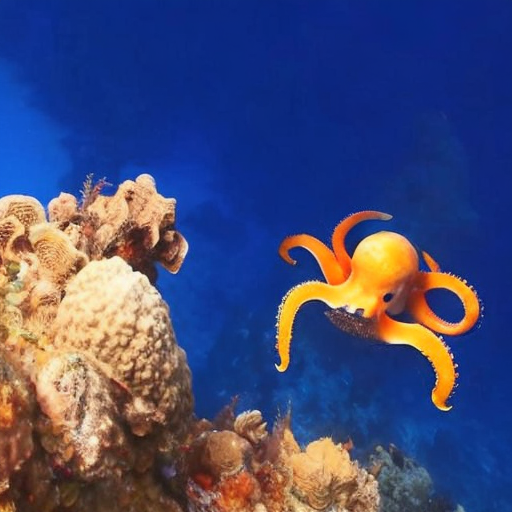

In [104]:
prompt = "huge orange octopus"
#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
image_inpainting = stdiff(prompt=prompt, image=pil_image_source_for_inpaint, mask_image=pil_image_mask_for_inpaint).images[0]
